## AS - TP2 - Mini-Batch, train/test et implémentation de critère

In [4]:
 require 'nn'
 require 'gnuplot'

 ---------------------------------------------
 -------------- DATA MNIST  ------------------
 ---------------------------------------------

local load_mnist = require 'load_mnist'
x_train,y_train=load_mnist.get_train(2,3)
x_test,y_test=load_mnist.get_test(2,3)
 -- 1: Creation du jeux de données
 local DIMENSION=x_train:size(2)

---------------------------------------------
-------------- CREATE MODEL -----------------
---------------------------------------------
 local model= nn.Linear(DIMENSION, 1)
 local criterion= nn.MSECriterion()
 model:reset(0,1)

 ---------------------------------------------
 -------------- PREPARE BATCH ----------------
 --------------VECTOR ACCURACY ---------------
 --------------NO VECTOR ACCURACY-------------

function Prepare_batch()
   batch_size=25
   --local nb_batch=torch.round(x_train:size(1)/batch_size)+1
   shuffle = torch.randperm(x_train:size(1))
   x_batch = shuffle:chunk(batch_size,1)
   y_batch = shuffle:chunk(batch_size,1)
   return x_batch,y_batch,batch_size
end


function Accuracy_vect(y,out)
    cumul=torch.cmul(torch.sign(y),torch.sign(out))
    acc=torch.mean(cumul)
    return acc
end

function Accuracy_novect(y,out)
  for i=1,out:size(1) do
      if(out[i]*y[i]>0) then
        sum=sum+1
      end
  end
  acc=sum/out:size(1)
  return acc
end




--------------------------------------------
--------------TESTING ----------------------
--------------------------------------------

function Eval(xtest,ytest)
    output = model:forward(xtest)
    return Accuracy_vect(ytest,output)
end
---------------------------------------------
-------------- TRAINNING  -------------------
---------------------------------------------
 local learning_rate= 0.001
 local maxEpoch= 150
 local all_losses={}
 local all_Eval={}
 local timer = torch.Timer()
 local acc=0

for iteration=1,maxEpoch do
    x_batch,y_batch,batch_size=Prepare_batch()
    loss=0
    acc=Eval(x_test,y_test)
    table.insert(all_Eval,acc)
    for i=1,batch_size do
        model:zeroGradParameters()
        --Forward pass
            -- Transform Table to Long ---> index(dim,torch.LongTensor))
        
        output = model:forward(x_train:index(1,x_batch[i]:long()))
        loss = loss + criterion:forward(output,y_train:index(1,y_batch[i]:long()))
        
        --Backward pass
        delta = criterion:backward(output,y_train:index(1, y_batch[i]:long()))
        model:backward(x_train:index(1,x_batch[i]:long()),delta)
        model:updateParameters(learning_rate)
    end
    table.insert(all_losses,loss)

   --gnuplot.plot('eval acc',torch.Tensor(all_Eval))
   --gnuplot.plot('train loss',torch.Tensor(all_losses))

end

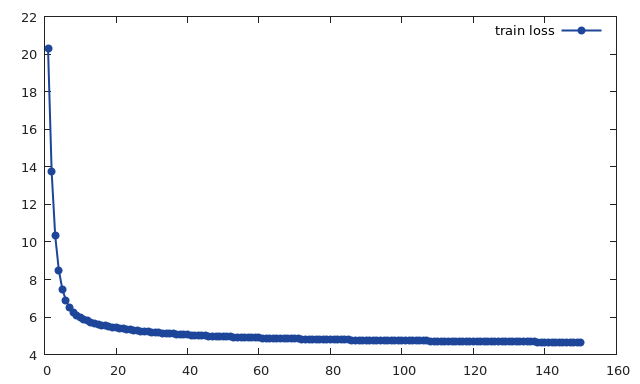

In [3]:
itorch.image('loss_mini_batch')

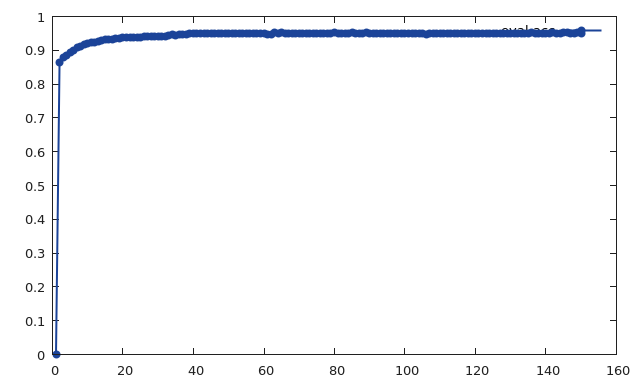

In [5]:
itorch.image('acc_test')

In [7]:
local HuberCriterion, parent = torch.class('HuberCriterion', 'nn.Criterion') -- heritage en torch

function HuberCriterion:__init() -- constructeur
-- equivalent a parent.__init(self)
self.gradInput = torch.Tensor(1)
self.output = 0
self.delta=1
end

function HuberCriterion:forward(input, target) -- appel generique pour calculer le cout
return self:updateOutput(input, target)
end

function HuberCriterion:updateOutput(input, target) 
    if torch.abs(input[1] - target[1]) < self.delta then
        self.output=1/2*torch.pow((input[1]-target[1]),2)
    else 
        self.output=self.delta*torch.abs(input[1]-target[1])-1/2*torch.pow(self.delta,2)
    end
    return self.output
end

function HuberCriterion:backward(input, target) -- appel generique pour calculer le gradient du cout
    return self:updateGradInput(input, target)
end

function HuberCriterion:updateGradInput(input, target)
    if (torch.abs(input[1]- target[1])<self.delta) then
        self.gradInput[1]=(input[1]-target[1])
    else 
        if(input[1]-target[1]>0) then 
            self.gradInput[1]=self.delta*1
        else
            self.gradInput[1]=self.delta*(-1)
        end
    end
    
    return self.gradInput
end
